# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 97697480.38it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
cls=train.classes

# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [8]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # CONVOLUTION BLOCK C2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # TRANSITION BLOCK 1
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=1, bias=False),
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

        # CONVOLUTION BLOCK C3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 16
        # CONVOLUTION BLOCK C4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1, 64),
            nn.Dropout(dropout_value)
        ) # output_size = 16
        # CONVOLUTION BLOCK C5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 16

       # TRANSITION BLOCK 2
        self.c6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=1, bias=False)
        ) # output_size = 16
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8

        # CONVOLUTION BLOCK C7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1, 16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        # CONVOLUTION BLOCK C8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        # CONVOLUTION BLOCK C9
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1, 32),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1
        # CONVOLUTION BLOCK C10
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.c3(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.c6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           4,608
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 34, 34]             256
        MaxPool2d-10           [-1, 16, 17, 17]               0
           Conv2d-11           [-1, 32, 17, 17]           4,608
             ReLU-12           [-1, 32, 17, 17]               0

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4706908464431763 Batch_id=390 Accuracy=32.37: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s]



Test set: Average loss: 1.5757, Accuracy: 4208/10000 (42.08%)

EPOCH: 1


Loss=1.280116319656372 Batch_id=390 Accuracy=47.07: 100%|██████████| 391/391 [00:18<00:00, 20.67it/s]



Test set: Average loss: 1.4452, Accuracy: 4846/10000 (48.46%)

EPOCH: 2


Loss=1.1560068130493164 Batch_id=390 Accuracy=54.87: 100%|██████████| 391/391 [00:19<00:00, 20.42it/s]



Test set: Average loss: 1.1050, Accuracy: 5992/10000 (59.92%)

EPOCH: 3


Loss=1.1995412111282349 Batch_id=390 Accuracy=59.88: 100%|██████████| 391/391 [00:20<00:00, 19.47it/s]



Test set: Average loss: 1.0694, Accuracy: 6145/10000 (61.45%)

EPOCH: 4


Loss=0.9226272702217102 Batch_id=390 Accuracy=63.04: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]



Test set: Average loss: 0.9895, Accuracy: 6432/10000 (64.32%)

EPOCH: 5


Loss=0.9862498044967651 Batch_id=390 Accuracy=65.41: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.9111, Accuracy: 6777/10000 (67.77%)

EPOCH: 6


Loss=0.7434316873550415 Batch_id=390 Accuracy=70.46: 100%|██████████| 391/391 [00:20<00:00, 19.48it/s]



Test set: Average loss: 0.8481, Accuracy: 6940/10000 (69.40%)

EPOCH: 7


Loss=0.7769686579704285 Batch_id=390 Accuracy=71.15: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]



Test set: Average loss: 0.8340, Accuracy: 7024/10000 (70.24%)

EPOCH: 8


Loss=0.9239565134048462 Batch_id=390 Accuracy=71.39: 100%|██████████| 391/391 [00:20<00:00, 19.39it/s]



Test set: Average loss: 0.8278, Accuracy: 7031/10000 (70.31%)

EPOCH: 9


Loss=0.7001382112503052 Batch_id=390 Accuracy=71.64: 100%|██████████| 391/391 [00:18<00:00, 21.35it/s]



Test set: Average loss: 0.8321, Accuracy: 6995/10000 (69.95%)

EPOCH: 10


Loss=0.7657535076141357 Batch_id=390 Accuracy=72.09: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 0.8100, Accuracy: 7122/10000 (71.22%)

EPOCH: 11


Loss=0.8703476190567017 Batch_id=390 Accuracy=72.49: 100%|██████████| 391/391 [00:18<00:00, 21.32it/s]



Test set: Average loss: 0.8110, Accuracy: 7094/10000 (70.94%)

EPOCH: 12


Loss=0.5911417007446289 Batch_id=390 Accuracy=72.97: 100%|██████████| 391/391 [00:18<00:00, 20.72it/s]



Test set: Average loss: 0.8000, Accuracy: 7143/10000 (71.43%)

EPOCH: 13


Loss=0.6879107356071472 Batch_id=390 Accuracy=73.16: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]



Test set: Average loss: 0.7969, Accuracy: 7137/10000 (71.37%)

EPOCH: 14


Loss=0.9795173406600952 Batch_id=390 Accuracy=73.22: 100%|██████████| 391/391 [00:20<00:00, 19.50it/s]



Test set: Average loss: 0.7955, Accuracy: 7135/10000 (71.35%)

EPOCH: 15


Loss=1.0168778896331787 Batch_id=390 Accuracy=73.20: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]



Test set: Average loss: 0.7965, Accuracy: 7143/10000 (71.43%)

EPOCH: 16


Loss=0.8025227785110474 Batch_id=390 Accuracy=73.27: 100%|██████████| 391/391 [00:17<00:00, 21.85it/s]



Test set: Average loss: 0.7954, Accuracy: 7144/10000 (71.44%)

EPOCH: 17


Loss=0.8164607882499695 Batch_id=390 Accuracy=73.34: 100%|██████████| 391/391 [00:18<00:00, 21.64it/s]



Test set: Average loss: 0.7941, Accuracy: 7149/10000 (71.49%)

EPOCH: 18


Loss=0.8199432492256165 Batch_id=390 Accuracy=73.69: 100%|██████████| 391/391 [00:17<00:00, 21.87it/s]



Test set: Average loss: 0.7942, Accuracy: 7141/10000 (71.41%)

EPOCH: 19


Loss=0.9837307929992676 Batch_id=390 Accuracy=73.34: 100%|██████████| 391/391 [00:19<00:00, 20.36it/s]



Test set: Average loss: 0.7947, Accuracy: 7138/10000 (71.38%)



In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/ERA/ERA_S8/modelln.pth')

Text(0.5, 1.0, 'Test Accuracy')

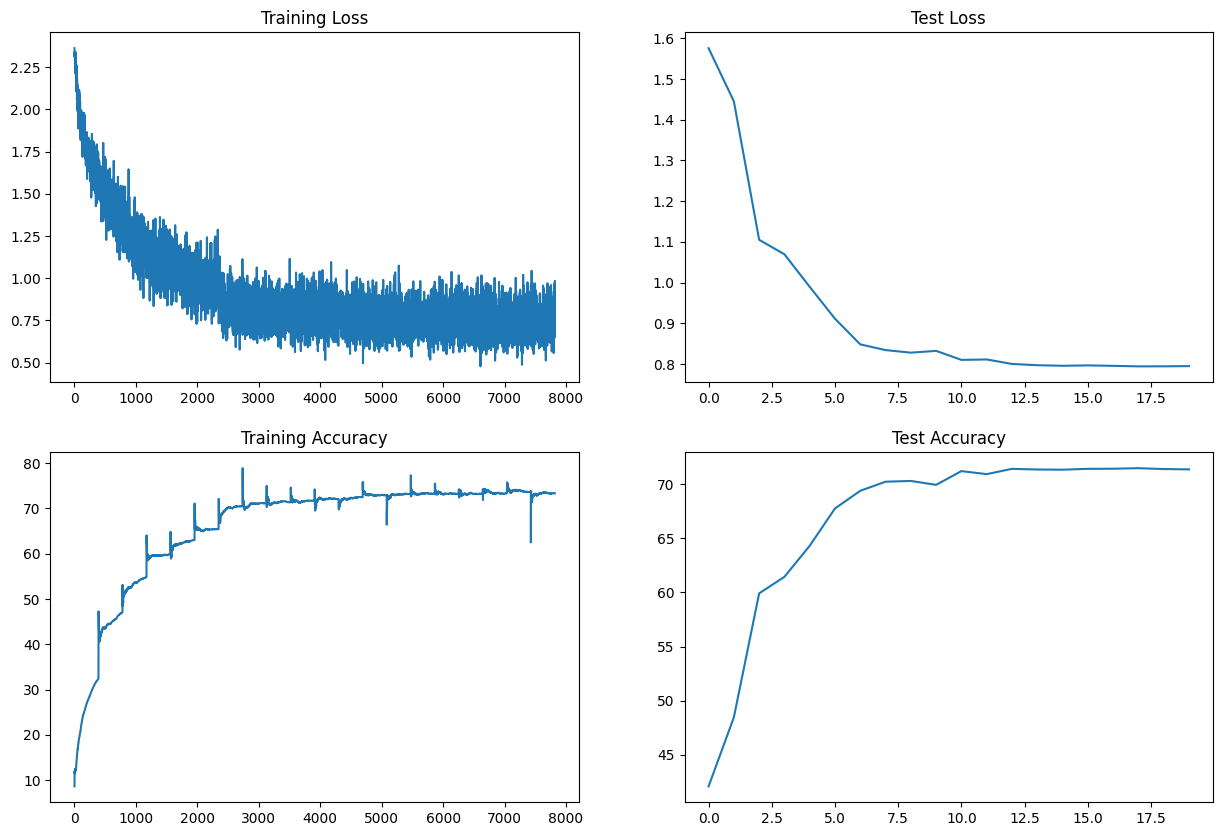

In [12]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(labels)
model.eval()
test_loss = 0
pred = []
with torch.no_grad():
  data, target = images.to(device), labels.to(device)
  output = model(data)
  test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
  p = output.argmax(dim=1, keepdim=True)
  print(p.tolist())
  #pred.append(output.argmax(dim=1, keepdim=True)[1].tolist()) # get the index of the max log-probability
pred = [t_items.item() for t_items in p]
target = [t_items.item() for t_items in target]
print('prediction:',pred)
print('target:',target)
res = [idx for idx, elem in enumerate(pred)
                           if elem != target[idx]]



tensor([5, 7, 4, 9, 0, 6, 7, 5, 3, 4, 7, 3, 8, 1, 0, 7, 7, 0, 9, 4, 0, 1, 8, 5,
        6, 8, 9, 2, 9, 9, 2, 4, 4, 9, 4, 2, 5, 9, 5, 5, 8, 8, 4, 5, 2, 6, 4, 9,
        4, 6, 0, 8, 2, 8, 9, 4, 0, 3, 8, 3, 1, 5, 1, 6, 2, 1, 2, 4, 6, 6, 6, 1,
        6, 2, 4, 4, 2, 5, 2, 7, 9, 6, 2, 8, 3, 5, 4, 4, 3, 0, 5, 3, 1, 1, 8, 5,
        1, 3, 3, 8, 0, 3, 1, 6, 6, 6, 7, 0, 1, 6, 5, 5, 8, 8, 8, 1, 5, 4, 8, 7,
        5, 3, 9, 7, 9, 9, 1, 1])
[[3], [9], [3], [9], [0], [6], [5], [5], [3], [4], [7], [3], [8], [1], [0], [5], [7], [6], [9], [4], [2], [1], [8], [3], [6], [8], [1], [2], [9], [8], [3], [4], [4], [9], [4], [2], [3], [9], [5], [2], [8], [8], [4], [3], [2], [6], [4], [9], [5], [6], [0], [8], [2], [8], [9], [4], [0], [3], [1], [5], [1], [8], [1], [6], [2], [3], [2], [4], [3], [3], [6], [1], [4], [7], [4], [4], [2], [5], [3], [5], [9], [3], [2], [1], [3], [3], [5], [4], [3], [0], [3], [5], [0], [9], [8], [5], [1], [5], [3], [1], [0], [6], [1], [6], [6], [6], [7], [0], [1], [4], [5], [5], [8], [

In [14]:
ind = [i for i in range(10)]
label_dict=dict(zip(ind,cls))
new = res[0:10]
print(len(new))

10


Text(0, 27, 'truck')

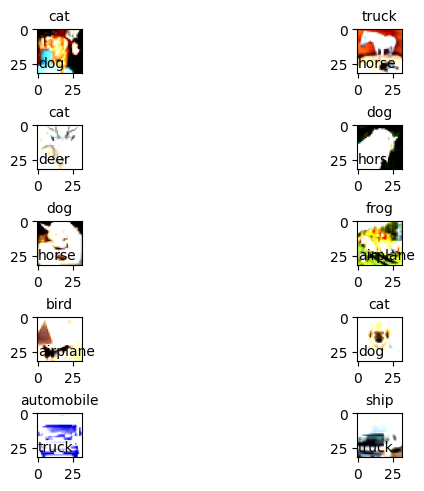

In [15]:
fig, axs = plt.subplots(5, 2 ,layout='constrained')
axs[0, 0].imshow(images[new[0]].permute((1, 2, 0)))
axs[0,0].set_title(label_dict[pred[new[0]]], fontsize = '10')
axs[0,0].annotate(label_dict[target[new[0]]], xy=(0,27),fontsize = '10')

axs[0, 1].imshow(images[new[1]].permute((1, 2, 0)))
axs[0,1].set_title(label_dict[pred[new[1]]], fontsize = '10')
axs[0,1].annotate(label_dict[target[new[1]]], xy=(0,27),fontsize = '10')

axs[1, 0].imshow(images[new[2]].permute((1, 2, 0)))
axs[1,0].set_title(label_dict[pred[new[2]]], fontsize = '10')
axs[1,0].annotate(label_dict[target[new[2]]], xy=(0,27),fontsize = '10')

axs[1, 1].imshow(images[new[3]].permute((1, 2, 0)))
axs[1,1].set_title(label_dict[pred[new[3]]], fontsize = '10')
axs[1,1].annotate(label_dict[target[new[3]]], xy=(0,27),fontsize = '10')

axs[2, 0].imshow(images[new[4]].permute((1, 2, 0)))
axs[2,0].set_title(label_dict[pred[new[4]]], fontsize = '10')
axs[2,0].annotate(label_dict[target[new[4]]], xy=(0,27),fontsize = '10')

axs[2, 1].imshow(images[new[5]].permute((1, 2, 0)))
axs[2,1].set_title(label_dict[pred[new[5]]], fontsize = '10')
axs[2,1].annotate(label_dict[target[new[5]]], xy=(0,27),fontsize = '10')

axs[3, 0].imshow(images[new[6]].permute((1, 2, 0)))
axs[3,0].set_title(label_dict[pred[new[6]]], fontsize = '10')
axs[3,0].annotate(label_dict[target[new[6]]], xy=(0,27),fontsize = '10')

axs[3, 1].imshow(images[new[7]].permute((1, 2, 0)))
axs[3,1].set_title(label_dict[pred[new[7]]], fontsize = '10')
axs[3,1].annotate(label_dict[target[new[7]]], xy=(0,27),fontsize = '10')

axs[4, 0].imshow(images[new[8]].permute((1, 2, 0)))
axs[4,0].set_title(label_dict[pred[new[8]]], fontsize = '10')
axs[4,0].annotate(label_dict[target[new[8]]], xy=(0,27),fontsize = '10')

axs[4, 1].imshow(images[new[9]].permute((1, 2, 0)))
axs[4,1].set_title(label_dict[pred[new[9]]], fontsize = '10')
axs[4,1].annotate(label_dict[target[new[9]]], xy=(0,27),fontsize = '10')


